<a href="https://colab.research.google.com/github/Manuelstv/Valuation/blob/main/balan%C3%A7o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baixando dados dos Balanços das Empresas Listadas em Bolsa

### Base de Dados CVM

http://dados.cvm.gov.br

In [1]:
!pip install wget
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import pandas_datareader.data as web
import seaborn as sns
import random

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import wget
from zipfile import ZipFile

plt.rcParams['figure.figsize'] = (12.5,4.5)
plt.rcParams.update({'font.size': 10})

import warnings
warnings.filterwarnings('ignore')

!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf
yf.pdr_override()

from scipy.stats import norm,t

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=9e1e036558a36fd9640c316bc9abe7cd8a6f5ddfb505414600f66d8a502d949f
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
     |████████████████████████████████| 5.5MB 18.6MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=0b6921413b246b0c691842a0af894620684b9eab9ca4161102627516b843b70b
  Stored in directory: /tmp/pip-ephem-wheel-cache-4zsv23si/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


## Acessando a base de dados e criando arquivos históricos

In [2]:
url_base = 'http://dados.cvm.gov.br/dados/CIA_ABERTA/DOC/ITR/DADOS/'

* criando uma lista com o nome de todos os arquivos

In [3]:
arquivos_zip = []
for ano in range(2011,2021):
  arquivos_zip.append(f'itr_cia_aberta_{ano}.zip')

arquivos_zip

['itr_cia_aberta_2011.zip',
 'itr_cia_aberta_2012.zip',
 'itr_cia_aberta_2013.zip',
 'itr_cia_aberta_2014.zip',
 'itr_cia_aberta_2015.zip',
 'itr_cia_aberta_2016.zip',
 'itr_cia_aberta_2017.zip',
 'itr_cia_aberta_2018.zip',
 'itr_cia_aberta_2019.zip',
 'itr_cia_aberta_2020.zip']

* fazendo o download de todos os arquivos

In [4]:
for arq in arquivos_zip:
  wget.download(url_base+arq)

* extraindo os arquivos zip

In [5]:
for arq in arquivos_zip:
  ZipFile(arq, 'r').extractall('CVM')

* criandos arquivos históricos

In [6]:
#nomes = ['BPA_con', 'BPA_ind', 'BPP_con', 'BPP_ind', 'DFC_MD_con', 'DFC_MD_ind', 'DFC_MI_con', 'DFC_MI_ind', 'DMPL_con', 'DMPL_ind', 'DRE_con', 'DRE_ind', 'DVA_con', 'DVA_ind']
nomes = ['DRE_con', 'DMPL_con']
for nome in nomes:
  arquivo = pd.DataFrame()
  #arquivo2 =pd.DataFrame()
  for ano in range(2011,2021):
    arquivo = pd.concat([arquivo, pd.read_csv(f'CVM/itr_cia_aberta_{nome}_{ano}.csv', sep=';', decimal=',', encoding='ISO-8859-1')])
    #arquivo2 = pd.concat([arquivo2, pd.read_csv(f'CVM/itr_cia_aberta_{ano}.csv', sep=';', decimal=',', encoding='ISO-8859-1')])

  arquivo.to_csv(f'itr_cia_aberta_{nome}_2011-2021', index=False)
  #arquivo2.to_csv(f'links', index=False)

In [7]:
dre = pd.read_csv('/content/itr_cia_aberta_DRE_con_2011-2021')
dmpl = pd.read_csv('/content/itr_cia_aberta_DMPL_con_2011-2021')

In [8]:
def filtro_empresa(demo, nome_cia):
  df = demo[demo.DENOM_CIA == nome_cia]
  df['DF_REFER'] = pd.to_datetime(df['DT_REFER'])
  df = df.set_index(df['DT_REFER'])
  df = df[df.ORDEM_EXERC == 'ÚLTIMO']
  df = df[['CD_CVM','DT_INI_EXERC','ORDEM_EXERC','DT_FIM_EXERC','CD_CONTA','DS_CONTA','VL_CONTA']]
  return df

In [9]:
def coleta_dre(cd_conta, dem):
  df = dem[dem['CD_CONTA'] == cd_conta]
  df = df.drop_duplicates(subset=['DT_INI_EXERC'])
  df.index = pd.to_datetime(df.index)
  df['VL_CONTA'] = df[['VL_CONTA']].rolling(4).sum()
  df.dropna(inplace=True)
  return df

In [10]:
def coleta_dmpl(cd_conta, dem):
  df = dem[dem['CD_CONTA'] == cd_conta]
  df = df.drop_duplicates(subset=['DT_INI_EXERC'])
  df.index = pd.to_datetime(df.index)
  #df['VL_CONTA'] = df[['VL_CONTA']].rolling(4).sum()
  df.dropna(inplace=True)
  return df

In [11]:
def cotacoes(start,end,ticker_cia, interval, nome_cia):
  ativo = pd.DataFrame()
  ativo[[nome_cia]] = yf.download(ticker_cia, start = start, end = end, interval = interval)[["Adj Close"]]
  return ativo

In [12]:
def razao(df, name, ativo, nome_cia):
  ativo[name] = np.nan
  for i in range (0,len(ativo)):
    for k in range(0,len(df)):
      if (ativo.index[i]>=df.index[k]):
        ativo[name].iloc[i] = df['VL_CONTA'].iloc[k]

  ativo['preco/'+ name] = ativo[nome_cia]/ativo[name]
  return ativo[['preco/'+ name]]

In [13]:
def linear(X,y):
  regressor = LinearRegression()
  regressor.fit(X, y)
  y_pred = regressor.predict(X)
  return X,y_pred

In [14]:
def poli(X,y,degree):
  X_seq = np.linspace(X.min(),X.max(),300).reshape(-1,1)
  degree=2
  polyreg=make_pipeline(PolynomialFeatures(degree),LinearRegression())
  polyreg.fit(X,y)
  y_pred = polyreg.predict(X_seq)
  return X_seq, y_pred

In [96]:
#Alguns nomes arbitrarios...
tickers_cias = ['bbas3.sa','ciel3.sa','petr3.sa','vale3.sa','ggbr3.sa','lren3.sa', 'csna3.sa','bbdc3.sa','wege3.sa','grnd3.sa','cgra3.sa','qual3.sa','vvar3.sa','mglu3.sa','itub3.sa','cogn3.sa','suzb3.sa','rent3.sa','ntco3.sa']
nomes_cias = ['BCO BRASIL S.A.', 'CIELO S.A.','PETROLEO BRASILEIRO S.A. PETROBRAS','VALE S.A.','GERDAU S.A.','LOJAS RENNER S.A.','CIA SIDERURGICA NACIONAL','BCO BRADESCO S.A.','WEG S.A.','GRENDENE S.A.','GRAZZIOTIN S.A.','QUALICORP CONSULTORIA E CORRETORA DE SEGUROS S.A.', 'VIA VAREJO S.A.','MAGAZINE LUIZA S.A.','ITAU UNIBANCO HOLDING S.A.','COGNA EDUCAÇÃO S.A.','SUZANO HOLDING S.A.','LOCALIZA RENT A CAR S.A.','NATURA COSMETICOS S.A.']
numero_empresas = len(nomes_cias)


df = pd.DataFrame()

for i in range (0, numero_empresas):
  df[[nomes_cias[i]]] = cotacoes(start = '2010-01-01', end = '2020-09-01', ticker_cia=tickers_cias[i], interval='1d', nome_cia = nomes_cias[i])
  
  dre_df = filtro_empresa(demo = dre, nome_cia = nomes_cias[i])
  dmpl_df = filtro_empresa(demo = dmpl, nome_cia = nomes_cias[i])
  
  df_receita = coleta_dre(cd_conta = '3.01', dem = dre_df)
  df_pat_liq = coleta_dmpl(cd_conta = '5.01', dem = dmpl_df)
  #df = df.loc[df_receita.index[0]:]
  
  df[nomes_cias[i]+'_preco/receita'] = razao(df = df_receita, name = 'receita', ativo = df[[nomes_cias[i]]], nome_cia = nomes_cias[i])
  df[nomes_cias[i]+'_preco/pat_liq'] = razao(df = df_pat_liq, name = 'pat_liq', ativo = df[[nomes_cias[i]]], nome_cia = nomes_cias[i])
  
  window = 750
  df[nomes_cias[i]+'_retorno'] = df[nomes_cias[i]].pct_change()
  df[nomes_cias[i]+'_retorno_acumulado'] = (1+df[nomes_cias[i]+'_retorno']).shift(-window).rolling(window=window).apply(np.prod, raw=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [97]:
numero_colunas = len(df.columns)
step = numero_colunas/numero_empresas

ativo = pd.DataFrame()
ativo['retorno_acumulado'] = df.iloc[:,np.arange(4,df.shape[1],step = step)].mean(axis=1)
ativo['preco/receita'] = df.iloc[:,np.arange(1,df.shape[1],step = step)].mean(axis=1)
ativo['preco/pat_liq'] = df.iloc[:,np.arange(2,df.shape[1],step = step)].mean(axis=1)

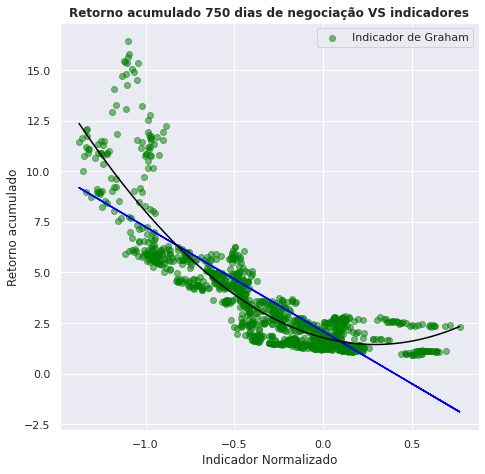

In [98]:
sns.set()
fig, axs = plt.subplots(figsize=(7.5,7.5), facecolor='w', edgecolor='k')
#standardization

ativo['std_preco/pat_liq'] = StandardScaler().fit_transform(ativo[['preco/pat_liq']])
#ativo['std_preco/lucro'] = StandardScaler().fit_transform(ativo[['preco/lucro']])
#ativo['std_preco/lpa'] = StandardScaler().fit_transform(ativo[['preco/lpa']])
ativo['std_preco/receita'] = StandardScaler().fit_transform(ativo[['preco/receita']])
  
ativo['graham'] = np.sqrt(ativo['preco/receita']*ativo['preco/pat_liq'])
ativo['std_graham'] = StandardScaler().fit_transform(ativo[['graham']])

my_df = ativo[['std_graham','retorno_acumulado']].dropna()
X = my_df[['std_graham']]
y = my_df[['retorno_acumulado']]

#Eegressão linear
X,y_pred = linear(X,y)
axs.plot(X, y_pred, color = 'blue')
  
#Regressao polinomial
X_seq,y_pred2 = poli(X,y,degree = 3)
axs.plot(X_seq,y_pred2,color="black")

axs.scatter(y = ativo['retorno_acumulado'],x = ativo['std_graham'], marker='o', color='green', label = 'Indicador de Graham', alpha =0.5)
#axs.scatter(y = ativo['retorno_acumulado'],x = ativo['std_preco/pat_liq'], marker='o', color='blue', label = 'preco/pat_liq',alpha =0.5)
#axs.scatter(y = ativo['retorno_acumulado'],x = ativo['std_preco/receita'], marker='o', color='red', label = 'Preco/receita',alpha =0.5)
  
axs.set_title('Retorno acumulado {} dias de negociação VS indicadores'.format(window), fontsize=12, fontweight ="bold")
#axs.set_xlim(-3,3)
axs.set_xlabel("Indicador Normalizado")
axs.set_ylabel("Retorno acumulado")
axs.legend()

axs=axs

In [105]:
from numpy import NaN
import plotly.graph_objs as go
from datetime import datetime

color = 'tab:red'

ativo['date'] = ativo.index

date_to_val = ativo['date'].map(pd.Series(data=np.arange(len(ativo)), index=ativo['date'].values).to_dict())
tickvals = [220*k for k in range(12)]
dlist = list(date_to_val)
index_tickvals = [dlist.index(tv) for tv in tickvals]

ticktext = [ativo['date'][id].strftime("%y-%m-%d") for id in index_tickvals]

customdata = [each_date.strftime("%y-%m-%d") for each_date in ativo['date']]
fig= go.Figure(go.Scatter(x= ativo['std_preco/pat_liq'], y=ativo['retorno_acumulado'], mode='markers',
                          marker_color=date_to_val, 
                          marker_colorscale='Plasma',
                          marker_showscale=True,
                          marker_size=8,
                          marker_colorbar=dict(tickvals=tickvals, 
                                               ticktext=ticktext),
                         customdata=customdata,
                         hovertemplate="%{customdata}<br>x: %{x}<br>y: %{y}"))

fig.update_layout(width=700, title_text='Retorno x P*a/vp', title_x=0.5)